In [5]:
%load_ext autoreload
%autoreload 2

import polars as pl 
pl.Config.set_streaming_chunk_size(50_000)
print('Polars is using', pl.thread_pool_size(), 'threads')
from datetime import date as Date
from pprint import pprint
import shutil
import mnemosyne as ms
from atlas.caching import cache_parquet 
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Polars is using 32 threads


In [7]:
peg_symbol = 'USDT'
dataset_type = ms.DatasetType.BinanceSpotTrades
hive_path = Path(dataset_type.hive_path(peg_symbol))

dev_version = 0
engine = 'streaming'
grid_interval = '10m'
db = pl.scan_parquet(hive_path / '**/data.parquet', hive_partitioning=True)
universe_df = pl.read_parquet(hive_path / "**/universe.parquet")

# @cache_parquet(LIB_CACHE_PATH, version=dev_version)
def get_head() -> pl.DataFrame:
    return db.head(5).collect(engine=engine)

teaser = get_head()
start_date = teaser['date'][0]
end_date = universe_df['date'].max()
print(f'{start_date} to {end_date}: {len(universe_df)} symbol-date pairs.')
pprint(teaser.schema)
teaser

2022-01-01 to 2025-10-12: 686225 symbol-date pairs.
Schema([('trade_id', Int64),
        ('price', Float64),
        ('quantity', Float64),
        ('quote_quantity', Float64),
        ('time', Datetime(time_unit='us', time_zone=None)),
        ('is_buyer_maker', Boolean),
        ('is_best_match', Boolean),
        ('peg_symbol', String),
        ('date', Date),
        ('symbol', String)])


trade_id,price,quantity,quote_quantity,time,is_buyer_maker,is_best_match,peg_symbol,date,symbol
i64,f64,f64,f64,datetime[μs],bool,bool,str,date,str
58292176,2.391,3.0,7.173,2022-01-01 00:00:00.236,false,true,"""USDT""",2022-01-01,"""1INCH"""
58292177,2.391,7.0,16.737,2022-01-01 00:00:00.236,false,true,"""USDT""",2022-01-01,"""1INCH"""
58292178,2.391,10.0,23.91,2022-01-01 00:00:01.241,false,true,"""USDT""",2022-01-01,"""1INCH"""
58292179,2.391,10.0,23.91,2022-01-01 00:00:02.243,false,true,"""USDT""",2022-01-01,"""1INCH"""
58292180,2.391,10.0,23.91,2022-01-01 00:00:03.235,false,true,"""USDT""",2022-01-01,"""1INCH"""


In [ ]:
destination_path = BINANCE_DATA_PATH / f"grids/spot/last_trade/{grid_interval}"
sample_destination_path =  LIB_CACHE_PATH / f"binance/grids/spot/last_trade/{grid_interval}"
ms.utils.verify_directory(destination_path)

print('Reading from database at', hive_path)
print('Publishing to:', destination_path)

# Run below during dev

In [3]:
@ms.cache_parquet(LIB_CACHE_PATH, version=dev_version)
def prepare_sample() -> pl.DataFrame: 
    qslice = db.filter(pl.col('date').is_between(Date(2024, 12, 30), Date(2025, 1, 2)))
    df = qslice.collect(engine=engine)
    return df 

sample_df = prepare_sample()
sample_df.glimpse()

✅ Cache hit for 'prepare_sample'. Loading from '/home/nlyu/Data/mnemosyne/cache/prepare_sample_v1.parquet.lz4'.
Rows: 234758673
Columns: 10
$ trade_id                <i64> 2986716, 2986717, 2986718, 2986719, 2986720, 2986721, 2986722, 2986723, 2986724, 2986725
$ price                   <f64> 0.03424, 0.03423, 0.03423, 0.03424, 0.03424, 0.03425, 0.03425, 0.03425, 0.03421, 0.03421
$ quantity                <f64> 4700.9, 43.9, 14631.0, 10230.3, 4398.9, 6255.0, 4422.8, 145.9, 43.8, 2722.6
$ quote_quantity          <f64> 160.958816, 1.502697, 500.81913, 350.285472, 150.618336, 214.23375, 151.4809, 4.997075, 1.498398, 93.140146
$ time           <datetime[μs]> 2024-12-30 00:00:01.425000, 2024-12-30 00:00:06.225000, 2024-12-30 00:00:06.225000, 2024-12-30 00:00:10.250000, 2024-12-30 00:00:10.250000, 2024-12-30 00:00:14.486000, 2024-12-30 00:00:14.486000, 2024-12-30 00:00:20.313000, 2024-12-30 00:00:28.011000, 2024-12-30 00:00:28.011000
$ is_buyer_maker         <bool> False, True, True, True, Tr

# Prod run

In [6]:
def weighted_mean(price_expr: pl.Expr, volume_expr: pl.Expr, final_name: str) -> pl.Expr :
    """Calculates the volume-weighted average price."""
    return (price_expr.dot(volume_expr) / volume_expr.sum()).alias(final_name)

def grid_columns():
    """Streaming-friendly aggregations - no .filter()!"""
    
    # Booleans cast to 0/1, so multiply directly. Don't use filter here, since that will cause memory fallback
    is_taker_buy = ~pl.col('is_buyer_maker')  # Cast to int: True=1, False=0
    is_taker_sell = pl.col('is_buyer_maker')
    
    # --- Metadata ---
    yield pl.col('peg_symbol').last()
    
    # --- OHLCV ---
    yield pl.first('price').alias('open')
    yield pl.max('price').alias('high')
    yield pl.min('price').alias('low')
    yield pl.last('price').alias('close')
    yield pl.sum('quantity').alias('volume_base')
    yield pl.sum('quote_quantity').alias('volume_quote')
    yield pl.len().alias('trade_count')
    yield pl.last('time').alias('last_trade_time')
    
    # --- Taker Volumes (using multiplication) ---
    # When is_taker_buy=True (1), include quote_quantity; when False (0), contribute 0
    yield (pl.col('quote_quantity') * is_taker_buy).sum().alias('taker_buy_volume_quote')
    yield (pl.col('quote_quantity') * is_taker_sell).sum().alias('taker_sell_volume_quote')
    
    # --- VWAP (adjusted for multiplication) ---
    yield weighted_mean(
        pl.col('price'),
        pl.col('quote_quantity') * is_taker_buy,
        'vwap_taker_buy'
    )
    yield weighted_mean(
        pl.col('price'),
        pl.col('quote_quantity') * is_taker_sell,
        'vwap_taker_sell'
    )
    yield weighted_mean(
        pl.col('price'),
        pl.col('quantity'),
        'vwap_total_by_base'
    )

def grid_query(lf: pl.LazyFrame) -> pl.LazyFrame:
    return (
        lf
        .group_by(
            'symbol', 'date', pl.col('time').dt.truncate(every=grid_interval).alias('time_grid')
        )
        .agg(
            grid_columns()
        )
        .with_columns(
            # Actual time offset reports the time of the actual last trade, prior to the reported time. 
            actual_time_offset=pl.col('time_grid').dt.offset_by(grid_interval) - pl.col('last_trade_time'), 
            time=pl.col('time_grid')
        )
        .drop('last_trade_time', 'time_grid')
    )

# Cell below dev run only

In [5]:
sample_result = grid_query(sample_df.lazy()).collect(engine='streaming')
# sample_result = grid_query(sample_df.filter(pl.col('date') == Date(2025, 1, 1))
#     .filter(pl.col('symbol') == 'BTC'))
sample_result.lazy().sink_parquet(
    pl.PartitionByKey(sample_destination_path, by=['peg_symbol', 'date']), 
    mkdir=True
)
read_sample_result = pl.read_parquet(sample_destination_path, hive_partitioning=True)
shutil.rmtree(sample_destination_path)
sample_result

symbol,date,peg_symbol,open,high,low,close,volume_base,volume_quote,trade_count,taker_buy_volume_quote,taker_sell_volume_quote,vwap_taker_buy,vwap_taker_sell,vwap_total_by_base,actual_time_offset,time
str,date,str,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,duration[μs],datetime[μs]
"""FORTH""",2024-12-30,"""USDT""",5.508,5.513,5.488,5.488,915.58,5038.90735,109,2898.69919,2140.20816,5.509371,5.495607,5.503514,23s 622ms,2024-12-30 07:00:00
"""LTC""",2024-12-30,"""USDT""",98.51,98.95,98.11,98.92,2891.238,284797.08743,1017,141634.46847,143162.61896,98.599686,98.409497,98.503509,1s 595ms,2024-12-30 00:00:00
"""LTC""",2024-12-30,"""USDT""",102.1,102.41,101.91,102.04,2359.342,240920.90681,689,149389.59742,91531.30939,102.116001,102.110027,102.113601,3s 631ms,2024-12-30 06:40:00
"""SAND""",2024-12-30,"""USDT""",0.542,0.5437,0.5419,0.5426,146645.0,79597.3743,426,43530.9164,36066.4579,0.542773,0.54281,0.54279,1s 272ms,2024-12-30 23:10:00
"""SANTOS""",2024-12-30,"""USDT""",3.319,3.319,3.308,3.31,1616.1,5352.03488,58,2813.80932,2538.22556,3.311419,3.312012,3.311698,15s 180ms,2024-12-30 07:20:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPELL""",2025-01-01,"""USDT""",0.0007357,0.0007358,0.0007325,0.0007325,5.241109e6,3850.74557,91,1270.567343,2580.178227,0.000734,0.000735,0.000735,550090µs,2025-01-01 14:20:00
"""TIA""",2025-01-01,"""USDT""",4.809,4.818,4.799,4.8,23297.54,111972.9853,404,44454.76883,67518.21647,4.806077,4.806312,4.806215,13s 245931µs,2025-01-01 19:20:00
"""TIA""",2025-01-01,"""USDT""",4.852,4.869,4.848,4.853,16266.64,79026.13548,435,51406.06624,27620.06924,4.858942,4.85675,4.858172,12s 944103µs,2025-01-01 20:30:00


('simple π 17/17 ["symbol", "date", "peg_symbol", ... 14 other columns]\n'
 '   WITH_COLUMNS:\n'
 '   [[(col("time_grid").dt.offset_by(["1m"])) - '
 '(col("last_trade_time"))].alias("actual_time_offset"), '
 'col("time_grid").alias("time")] \n'
 '    AGGREGATE[maintain_order: false]\n'
 '      [col("peg_symbol").last(), col("price").first().alias("open"), '
 'col("price").max().alias("high"), col("price").min().alias("low"), '
 'col("price").last().alias("close"), '
 'col("quantity").sum().alias("volume_base"), '
 'col("quote_quantity").sum().alias("volume_quote"), '
 'len().alias("trade_count"), col("time").last().alias("last_trade_time"), '
 '[(col("quote_quantity")) * '
 '(col("is_buyer_maker").not().cast(Float64))].sum().alias("taker_buy_volume_quote"), '
 '[(col("quote_quantity")) * '
 '(col("is_buyer_maker").cast(Float64))].sum().alias("taker_sell_volume_quote"), '
 '[([(col("price")) * ([(col("quote_quantity")) * '
 '(col("is_buyer_maker").not().cast(Float64))])].sum()) / '
 '([

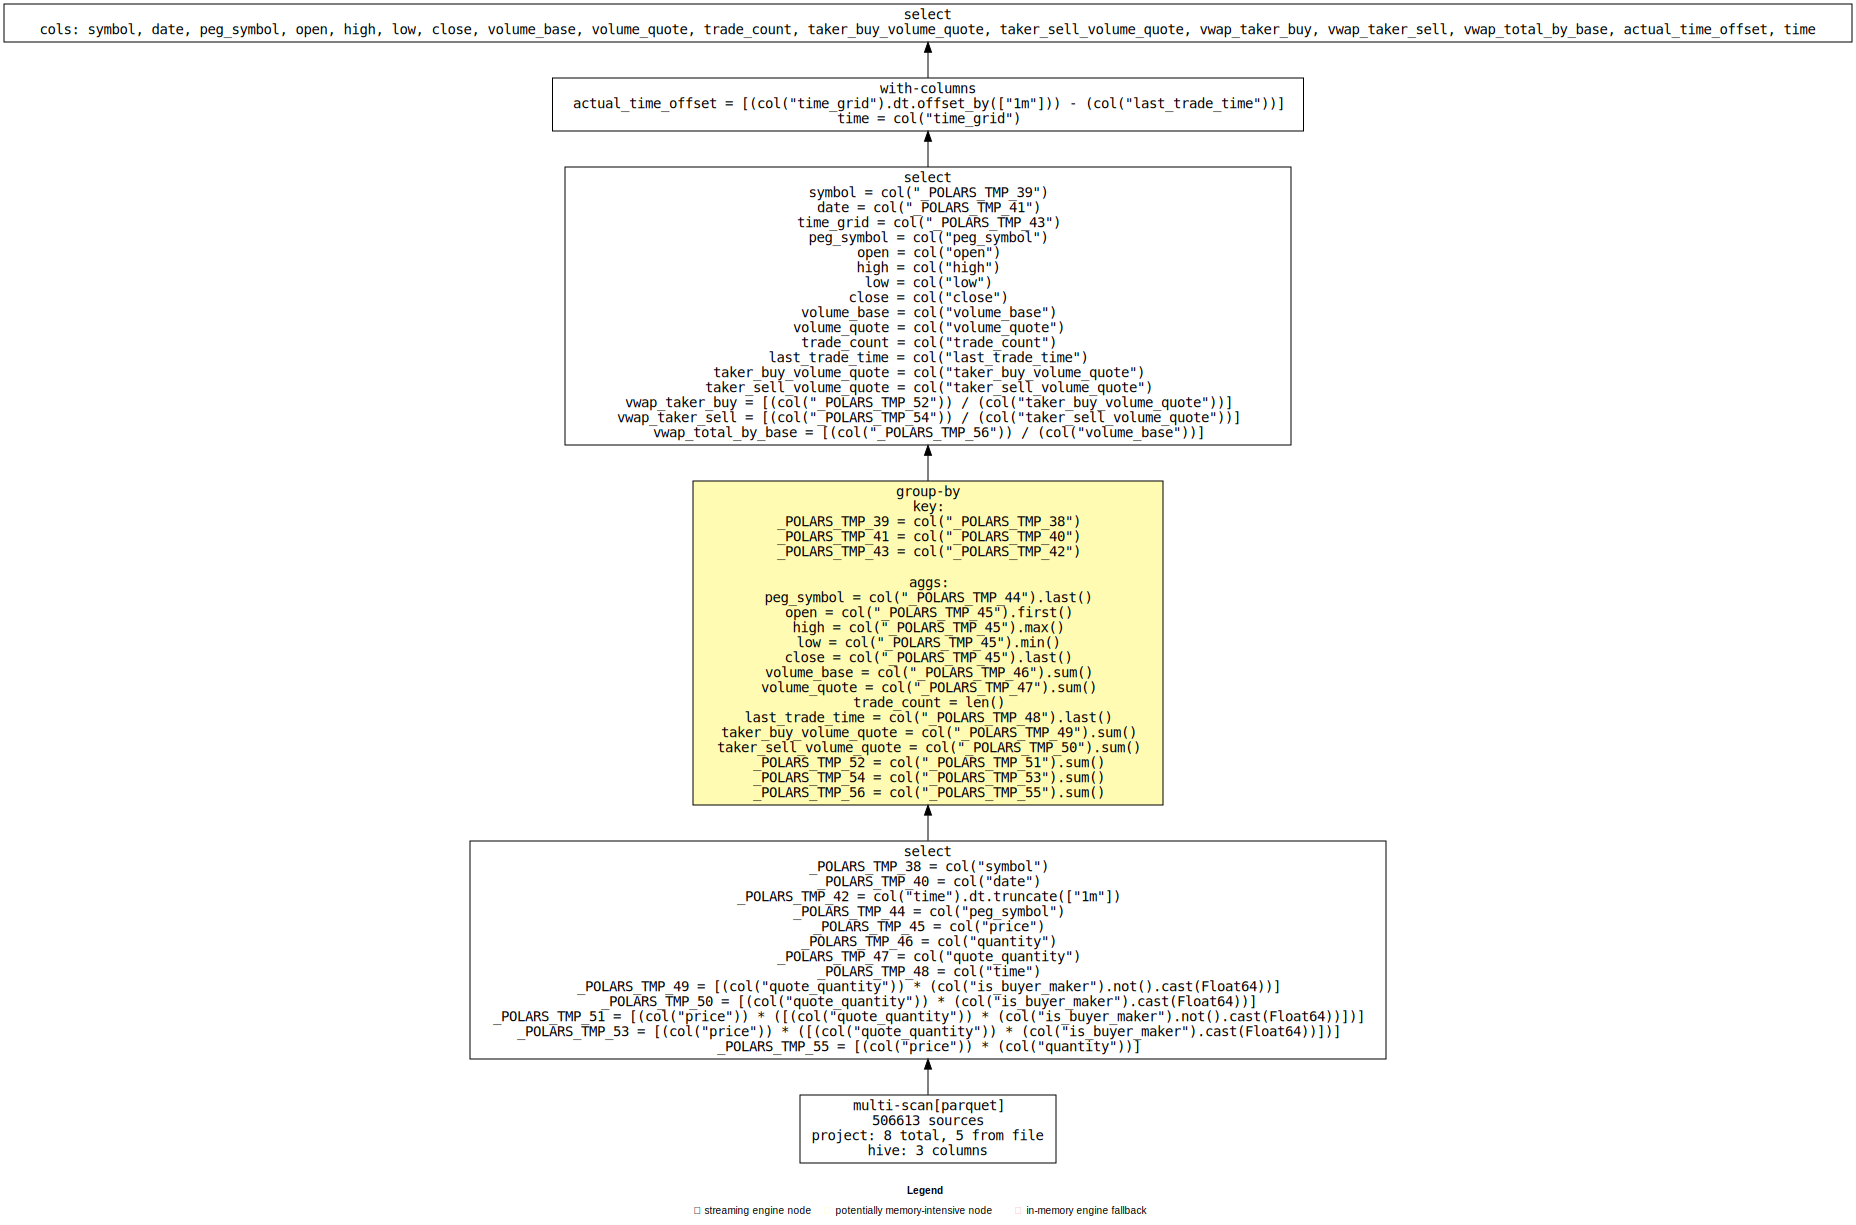

In [10]:
db_query = grid_query(db)
pprint(db_query.explain(engine=engine))
db_query.show_graph(engine=engine, plan_stage="physical")

# Prod run

In [7]:
# BATCHED PROCESSING - Process in weekly chunks to keep memory < 15GB per batch
# This preserves streaming + hive partitioning while avoiding 349GB peak

from datetime import timedelta
import gc

def process_date_batch(start_date: Date, end_date: Date):
    """Process a specific date range - keeps same query logic"""
    print(f"  Processing: {start_date} → {end_date}")
    # Filter to date range (Polars pushes this down to file scanning via hive partitioning!)
    batch_data = db.filter(
        pl.col('date').is_between(start_date, end_date)
    )
    
    # Apply same grid_query - streaming still works!
    batch_query = grid_query(batch_data)
    
    # Sink to same destination (appends to existing partitions)
    batch_query.sink_parquet(
        pl.PartitionByKey(destination_path, by=['peg_symbol', 'date'], 
                        per_partition_sort_by=pl.col('time')), 
        mkdir=True
    )
    
    # Force garbage collection to ensure memory is freed
    gc.collect()

print(f"\nDataset: {start_date} to {end_date}")
print(f"Destination: {destination_path}")
print(f"Engine: {engine}")

# Generate weekly batches
BATCH_DAYS = 30  # Adjust if needed: smaller = less memory, more iterations
batches = []
current_start = start_date

while current_start <= end_date:
    current_end = min(current_start + timedelta(days=BATCH_DAYS - 1), end_date)
    batches.append((current_start, current_end))
    current_start = current_end + timedelta(days=1)

print(f"Total batches: {len(batches)} ({BATCH_DAYS}-day chunks)\n")
print("="*70)

# Process all batches
for i, (start, end) in enumerate(batches, 1):
    print(f"[{i:3d}/{len(batches)}]", end=" ")
    process_date_batch(start, end)

print("="*70)
print(f"   Output: {destination_path}")


Dataset: 2022-01-01 to 2025-10-11
Destination: /home/nlyu/Data/mnemosyne/binance/grids/spot/last_trade/1m
Engine: streaming
Total batches: 46 (30-day chunks)

[  1/46]   Processing: 2022-01-01 → 2022-01-30
[  2/46]   Processing: 2022-01-31 → 2022-03-01
[  3/46]   Processing: 2022-03-02 → 2022-03-31
[  4/46]   Processing: 2022-04-01 → 2022-04-30
[  5/46]   Processing: 2022-05-01 → 2022-05-30
[  6/46]   Processing: 2022-05-31 → 2022-06-29
[  7/46]   Processing: 2022-06-30 → 2022-07-29
[  8/46]   Processing: 2022-07-30 → 2022-08-28
[  9/46]   Processing: 2022-08-29 → 2022-09-27
[ 10/46]   Processing: 2022-09-28 → 2022-10-27
[ 11/46]   Processing: 2022-10-28 → 2022-11-26
[ 12/46]   Processing: 2022-11-27 → 2022-12-26
[ 13/46]   Processing: 2022-12-27 → 2023-01-25
[ 14/46]   Processing: 2023-01-26 → 2023-02-24
[ 15/46]   Processing: 2023-02-25 → 2023-03-26
[ 16/46]   Processing: 2023-03-27 → 2023-04-25
[ 17/46]   Processing: 2023-04-26 → 2023-05-25
[ 18/46]   Processing: 2023-05-26 → 2023-